# Compulsory assignment 1 - Using Dask-ml on large data
## Group #16
### Thomas Moen and Jørgen Kongsro

## Import libraries

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import os
import dask
import dask.dataframe as dd
import scipy
import matplotlib.pyplot as plt
import skimage.io
import dask.array as da
import joblib

from dask.diagnostics import ProgressBar
from dask_ml.linear_model import LogisticRegression
from dask_ml.model_selection import train_test_split
from dask_ml.datasets import make_classification
from dask_ml.model_selection import train_test_split
from dask_ml.linear_model import LogisticRegression
from dask_ml.metrics import accuracy_score
from dask_ml.model_selection import IncrementalSearchCV
from dask.distributed import Client

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

print (dask.__version__)

2.1.0


## Install Kaggle API and download Kaggle data

In [ ]:
# Install Kaggle API
# How to setup: https://github.com/Kaggle/kaggle-api
# or visit: https://adityashrm21.github.io/Setting-Up-Kaggle/

#!pip install kaggle

In [ ]:
# Download Kaggle data using Kaggle API
#!kaggle competitions download -c dat300-ca1-autumn-2019


In [ ]:
# Unzip Kaggle data
#!unzip "dat300-ca1-autumn-2019.zip" -d "/tmp/whatever"

## List files in directory (adjust for different operating systems)

In [2]:
# Adjust for different os

if os.name == 'nt':
    workdir = 'C://Users//thomoe//Documents//myDAT300//dat300-ca1-autumn-2019//'
elif os.name == 'posix':
    workdir = '/Users/jorgenkongsro/Downloads/dat300-ca1-autumn-2019/'
    
os.listdir(workdir)


['y_test_sampleSubmission.csv', 'X_train.csv', 'y_train.csv', 'X_test.csv']

## Import data

In [9]:
def import_data(csv_file):
    """ Import data from csv file

    :param data: a .csv separated dataset
    :return: a pandas data array, df
    
    """
    
    
    df = dd.read_csv(csv_file)
    return df

x_train_df = import_data(workdir + 'X_train.csv')
x_test_df = import_data(workdir + 'X_test.csv')
y_train_df = import_data(workdir + 'y_train.csv')

x_train_df
y_train_df

,Target
npartitions=1,
,float64
,...


### View data and study the structure

In [10]:
x_train_df

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162
npartitions=83,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [11]:
y_train_df

,Target
npartitions=1,
,float64
,...


## Check for missing data

In [ ]:
def percent_missing(dataframe):
    """ Check for percent missing values in dataframe
    :param data: dataframe
    :return: dataframe
    
    """
    missing_values = dataframe.isnull().sum()
    
    with ProgressBar():
        percent_missing = ((missing_values / dataframe.index.size) * 100).compute()
        
    return percent_missing


print(percent_missing(y_train_df))

"""
note: the results indicate that the features come in "tripets", e.g. f1 to f3 have quite similar missing%. 
We could impute some values very precisely by insert the mean of the other values within the triplet, 
if only one or two values are missing
"""

## Drop rows due to missing values in target

In [14]:
# Delete rows in x_train_df and y_train_df where 
# 1) y is NaN and/or 
# 2) x has more than N missing features
# Delete the same rows in x_train_df and y_train_df

#First inspect the distribution of missing values in rows of x_train_df, in order to decide on a threshold for culling rows: 
if dir().count('nacounts_rows') == 0:
    nacounts_rows = x_train_df.isna().sum(axis=1).compute()
nacounts_rows.plot.hist(bins=20, grid=True)

#Based on the histogram we chose to remove rows of x_train_df which had more than 150 missing features:
nacount_thresh = 150

#Make boolean list where True means the number of NaN's exceeds nacount_thresh for that row (of x_train_df):
rows_to_drop_x = list(nacounts_rows > nacount_thresh)

#Make boolean list where True means thaty_train_df is NaN for that row: 
rows_to_drop_y = list(y_train_df['Target'].isna().compute())

#Combine rows_to_drop_x and rows_to_drop_y and negate the list so that it becomes a boolean list of rows to keep: 
rows_to_keep = [not(rows_to_drop_x[a] or rows_to_drop_y[a]) for a in range(len(rows_to_drop_y))]

#Delete rows from x_train_df and y_train_df (we did not manage to do this without pandas dataframes from the dask dataframes): 
x_train_droprows = x_train_df.compute()[rows_to_keep]
y_train_droprows = y_train_df.compute()[rows_to_keep]

#...therefore we had to revert back to dask dataframe afterwards:
x_train_df_droprows=dd.from_pandas(x_train_droprows, npartitions=249) # npartitions based on viewing data structure in previous section
y_train_df_droprows=dd.from_pandas(y_train_droprows, npartitions=3) # npartitions based on viewing data structure in previous section

# Delete obsolete variables
del x_train_df, y_train_df



In [21]:
type(x_train_droprows)

pandas.core.frame.DataFrame

## Impute missing data

In [15]:
#choose here which imputation methods to use:
imputation_methods = ['correlated_columns', 'col_means']


In [16]:
#impute by inserting the mean of the column in question, for all columns: 
 
if 'col_means' in imputation_methods:
    
    #calculate mean (note that axis needs to be 0 to get columns, which is weird)
    miin = x_train_df_droprows.mean(axis = 0).compute() # Fill with mean value

    x_train_df_impute = x_train_df_droprows.fillna(dict(miin))

type(x_train_df_impute)

dask.dataframe.core.DataFrame

In [ ]:
#impute by inserting value from most closely correlated column: 

"""
I can't understand why this one doesn't work. The idea was to fill in NaN's from correlated columns.
The problem might be in the last line

"""

#will only correct if the correlation between columns is above this threshold: 
lowest_allowed_corr = 0.995

if 'correlated_columns' in imputation_methods:
    
    #if correlation matrix does not exist, first try to read it from file, if that does not work calculate it: 
    if dir().count('corrs') == 0: 
        try: 
            corrs = pd.read_csv(workdir + 'features_correlation_matrix.txt')
        except:
            corrs = x_train_df.corr('pearson')
    
    #impute for each feature feat:
    for feat in x_train_df_colnames:
        
        #order the feature names according to (absolute value of) correlations to feat:
        abscorr = [abs(a) for a in list(corrs[feat])]
        order = np.argsort(abscorr)[::-1]
        topfeatures = [x_train_df_colnames[a] for a in order]
        
        #remove features which are not sufficiently correlated to feat:
        mapper = dict(zip(x_train_df_colnames, abscorr))
        topfeatures = [a for a in topfeatures if mapper[a] >= lowest_allowed_corr]
        
        #correct using each feature in topfeatures, starting with the most strongly correlated otherfeature:
        for otherfeat in [a for a in topfeatures if a != feat]:
            print(feat, otherfeat)
            x_train_df_trim[feat] = x_train_df_trim[feat].fillna(x_train_df_trim[otherfeat]).compute()




## Build model and train

In [82]:
# Create dask array with chunks. Delete obsolete variables
X = x_train_df_impute
X = X.to_dask_array(lengths=True)
x_test = x_test_df
x_test = x_test.to_dask_array(lengths=True)
y = y_train_df_droprows
y = y.to_dask_array(lengths=True)
X
#del x_train_df_imean, x_train_df, y_train_df_imean, y_train_df

,Array,Chunk
Bytes,3.70 GB,14.97 MB
Shape,"(2858793, 162)","(11550, 162)"
Count,747 Tasks,249 Chunks
Type,float64,numpy.ndarray


In [91]:
# Convert blocks in dask array x for new chunks
X = X.rechunk((100000, 162))
y = y.rechunk((100000, 1))
y = y.flatten()
y

dask.array<reshape, shape=(2858793,), dtype=float64, chunksize=(100000,)>

In [93]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
#del X, y
X_train

dask.array<concatenate, shape=(2572913, 162), dtype=float64, chunksize=(90000, 162)>

### Parallelize Scikit-Learn

In [ ]:
client = Client()  # Connect to a Dask Cluster

from sklearn.ensemble import RandomForestClassifier 
model = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
with joblib.parallel_backend('dask'):
    model.fit(X_train, y_train)
    y_true = y_test
    y_pred = model.predict(X_test)

    
"""

We ran into memory error for the model.predict part of the code

"""

### Reimplement Scalable Algorithms with Dask Array

In [ ]:
from dask.diagnostics import ProgressBar

lr = LogisticRegression()
with ProgressBar():
    lr.fit(X_train, y_train)

"""

Takes a lot of time to compute

"""

[########################################] | 100% Completed | 16.4s
[#######################                 ] | 58% Completed | 19.0s

In [108]:
# Using grid search to tune hyperparameters
from dask_ml.model_selection import GridSearchCV

parameters = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}

lr = LogisticRegression()
tuned_lr = GridSearchCV(lr, parameters)

with ProgressBar():
    tuned_lr.fit(X_train, y_train)


[########################################] | 100% Completed | 30min 52.6s
[########################################] | 100% Completed |  1min 53.9s


### Run diagnostics

In [109]:
y_true = y_val
y_pred = tuned_lr.predict(X_val)
accuracy_score(y_true, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
AUC = metrics.auc(fpr, tpr)
F1 = f1_score(y_true, y_pred)

print (AUC)
print (F1)

0.1257484708371596

[[111375 154363]
 [  8434  11708]]


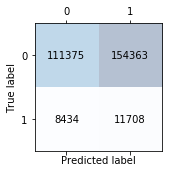

In [111]:
# Confusion matrix of test data
%matplotlib inline
confmat_test = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat_test, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_test.shape[0]):
    for j in range(confmat_test.shape[1]):
        ax.text(x=j, y=i, s=confmat_test[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

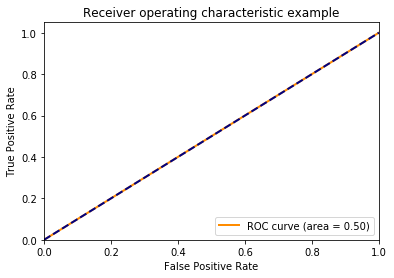

In [112]:
# Plot the ROC for your best model on the training data
# Compute ROC curve and ROC area for each class
%matplotlib inline
roc_auc=metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Make ready file to be submitted to Kaggle

In [103]:
# Predict using model and X_test standardized
y_pred = tuned_lr.predict(x_test)
YPRED = y_pred.compute()

np.mean(YPRED)
# Make list of IDs from 0 to 9999
ID = list(range(len(YPRED)))

# Make dataframes from predicted values, IDs and concatenate in result 
pred1 = pd.DataFrame(YPRED, index=None, columns=['Target'])
pred2 = pd.DataFrame(ID, index=None, columns=['id'])
result = pd.concat([pred2, pred1], axis=1)
result = result.astype(int) # change type to integers

# Read results to csv for publication on Kaggle
result.to_csv('jorgen.csv',index=False)

In [64]:
sample = pd.read_csv('sampleSubmission.csv') 
sample

709039

In [104]:
np.std(YPRED)

0.49227002458339675